# <div style="padding: 50px;color:white;margin:10;font-size:80%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#8fbc8f"><b><span style='color:#FFFFFF'></span></b> <b>IMAGE CLASSIFICATION USING CONVOLUTIONAL NEURAL NETWORK</b></div>

### **Tên nhóm: BN Team**
|Họ và tên|MSVV|
|---|---|
|Nguyễn Quang Gia Bảo|20120040|
|Nguyễn Thị Châu Ngọc|20120146|

### **Link github:** https://github.com/marco081116/applied_parallel_programming

### **Bảng phân chia công việc:**
|Thành viên|Công việc|Tiến độ hoàn thành|
|---|---|---|
|Nguyễn Quang Gia Bảo|- Nghiên cứu và cài đặt code tuần tự<br>- Huấn luyện và đánh giá mô hình ở các phiên bản<br> - Thiết kế, cài đặt, đánh giá phần song song hóa lớp Convolution <br>- So sánh thời gian chạy của các lớp ở phiên bản tuần tự và song song<br>- Viết report| 100% |
|Nguyễn Thị Châu Ngọc|- Nghiên cứu và cài đặt code tuần tự<br>- Mô tả, tiền xử lý, khám phá dữ liệu <br>- Thiết kế, cài đặt, đánh giá phần song song hóa lớp MaxPooling2D <br>-  Thiết kế, cài đặt, đánh giá phần song song hóa hàm Forward của lớp Dense<br>- Viết report |100%|

# __Import Libraries__

In [ ]:
# Import những thư viên cần thiết
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
# Sử dụng thư viện Keras để tiền xử lý hình ảnh.
from keras.preprocessing import image
import os
print(os.listdir("../input"))
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import cv2
from zipfile import ZipFile
from numba import cuda, types as numba_types
import time

Using TensorFlow backend.


['aerial-cactus-identification', 'dataset']


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#8fbc8f"><b><span style='color:#FFFFFF'>1 |</span></b> <b>BỘ DỮ LIỆU</b></div>

### <b><span style='color:#8FBC8F'> 1.1 |</span> Mô tả chung</b>
Bộ dữ liệu được lấy từ một cuộc thi được tổ chức trên Kaggle mang tên [Aerial Cactus Identification](https://www.kaggle.com/competitions/aerial-cactus-identification) (Nhận diện xương rồng từ trên không) với mục đích xác định liệu hình ảnh có chứa xương rồng hay không.

### <b><span style='color:#8FBC8F'> 1.2 |</span> Mô tả về cuộc thi</b>

Để đánh giá tác động của biến đổi khí hậu đối với hệ thực vật và động vật trên Trái Đất, việc xác định sự ảnh hưởng từ các hoạt động của con người như chặt phá, khai thác gỗ, và nông nghiệp đến các khu vực tự nhiên được bảo vệ của chúng ta là rất quan trọng. Các nhà nghiên cứu tại Mexico đã tạo dự án [VIGIA](https://jivg.org/research-projects/vigia/), mục tiêu xây dựng một hệ thống giám sát tự động cho các khu vực được bảo vệ. Một bước đầu tiên trong nỗ lực như vậy là khả năng nhận biết thực vật bên trong các khu vực được bảo vệ. Và nhiệm vụ trong cuộc thi này là tạo ra một thuật toán có thể nhận diện loại cây xương rồng cụ thể trong hình ảnh được chụp từ không gian.

### <b><span style='color:#8FBC8F'> 1.3 |</span> Mô tả về bộ dữ liệu</b>
**Thông tin sơ lược:**

Bộ dữ liệu này chứa một số lượng lớn hình ảnh thu nhỏ 32 x 32 chứa ảnh chụp từ trên cao của một loại cây xương rồng trụ (Neobuxbaumia tetetzo). Kaggle đã điều chỉnh kích thước ảnh từ bộ dữ liệu gốc để làm cho chúng cùng kích thước. Tên tệp của một hình ảnh tương ứng với id của nó.

Nhiệm vụ: Tạo một mô hình phân loại có khả năng dự đoán xem một hình ảnh có chứa cây xương rồng hay không.

**Thông tin cụ thể:**

Bộ dữ liệu gồm các file sau: 
-	train: các hình ảnh tập huấn luyện	
-	test: các hình ảnh tập kiểm tra
-	train.csv: các nhãn của tập huấn luyện, cho biết liệu hình ảnh có chứa cây xương rồng hay không (has_cactus = 1)
-	sample_submission.csv - một tệp nộp mẫu theo đúng định dạng.

Ở đây ta sẽ tập trung vào các file là train và train.csv để làm dữ liệu input cho mô hình CNN.



# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#8fbc8f"><b><span style='color:#FFFFFF'>2 |</span></b> <b>TẢI, TIỀN XỬ LÝ VÀ KHÁM PHÁ DỮ LIỆU</b></div>

### <b><span style='color:#8FBC8F'> 2.1 |</span> Tải dữ liệu</b>

In [ ]:
train_dir = "/kaggle/input/dataset/train/train/"
#test_dir ="/kaggle/input/dataset/test/test/"
# Tải file chứa nhãn của bộ dữ liệu
train_labels=pd.read_csv("/kaggle/input/dataset/train.csv")
print('Shape of train data:',train_labels.shape)
print('Number of labels in train data:\n', train_labels['has_cactus'].value_counts())

Shape of train data: (17500, 2)
Number of labels in train data:
 1    13136
0     4364
Name: has_cactus, dtype: int64


In [ ]:
# Tiền xử lý hình ảnh sử dụng thư viện keras
# Tạo list chứa nhãn của hình ảnh
label=[]
# Tạo list chưa ma trận hình ảnh
image_feature = []
image_id=train_labels['id']
for i in image_id:
    # Tải hình ảnh dưới dạng PIL format, có target size là (32,32,3)
    img=image.load_img(train_dir+i, target_size=(32,32))
    # Chuyển đổi hình ảnh dạng PIL thành mảng Numpy
    img = image.img_to_array(img)
    # Thực hiện chuẩn hóa hình ảnh bằng cách chia cho 255.0
    img = img/255.0
    image_feature.append(img)
    label.append(train_labels[train_labels['id'] == i]['has_cactus'].values[0])
# Tạo dataframe từ các hình ảnh đã tiền xử lý và nhãn tương ứng của chúng
list_of_tuples=list(zip(image_feature,label))
df = pd.DataFrame(list_of_tuples, columns = ['image', 'label'])
# Tạo dữ liệu input cho mô hình
X = np.array(image_feature)
y=pd.get_dummies(df['label']).values
# Chuyển đổi dữ liệu có dạng (number of images,number of channels,height image, width image)
X = X.transpose(0,3,1,2)

In [ ]:
# Chia dataset thành các tập train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print("Train Images:",X_train.shape[0])
print("Test Images:",X_test.shape[0])

Train Images: 14000
Test Images: 3500


### <b><span style='color:#8FBC8F'> 2.3 |</span> Khám phá dữ liệu</b>

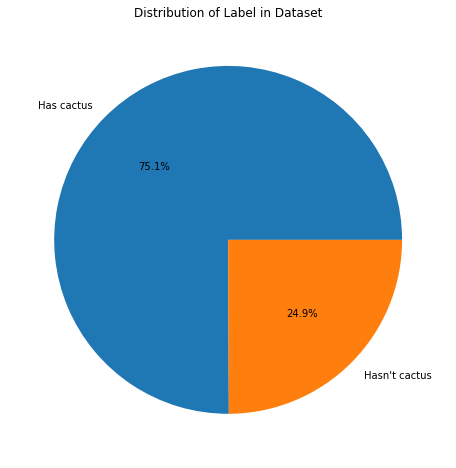

In [ ]:
plt.figure(figsize = (8,8))
plt.pie(train_labels['has_cactus'].value_counts(), labels=['Has cactus', 'Hasn\'t cactus'], autopct='%.1f%%')
plt.title('Distribution of Label in Dataset');

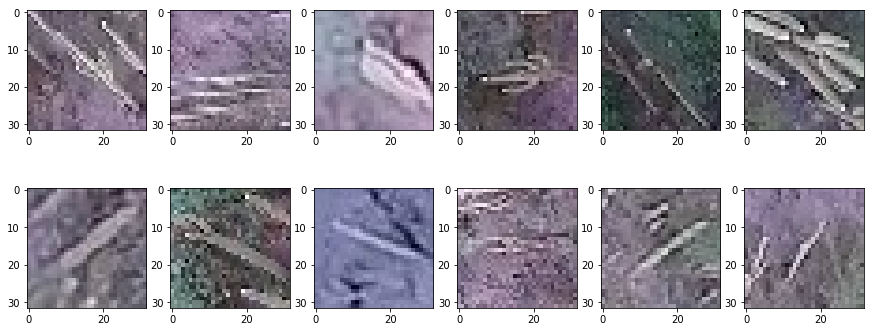

In [ ]:
# Trực quan hình ảnh thuộc lớp có xuất hiện hình ảnh xương rồng
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(2, 6)

last_has_cactus_img_name = train_labels[train_labels['has_cactus'] == 1]['id'][-12:]

for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = '/kaggle/input/dataset/train/train/' + img_name
    image = cv2.imread(img_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

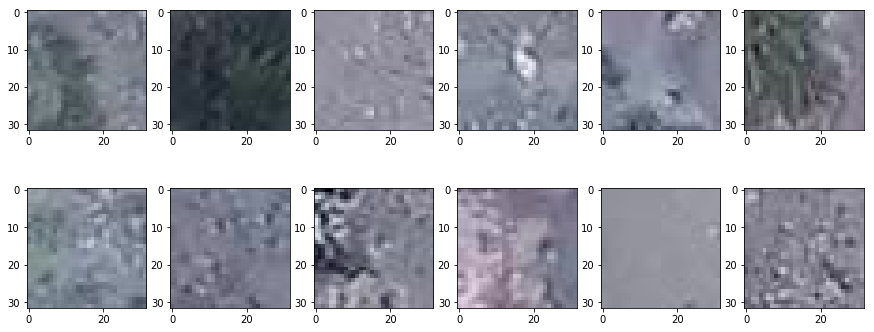

In [ ]:
# Trực quan hình ảnh thuộc lớp không có xuất hiện hình ảnh xương rồng
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(2, 6)

last_has_cactus_img_name = train_labels[train_labels['has_cactus'] == 0]['id'][-12:]

for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = '/kaggle/input/dataset/train/train/' + img_name
    image = cv2.imread(img_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#8fbc8f"><b><span style='color:#FFFFFF'>3 |</span></b> <b>CÀI ĐẶT CÁC HÀM </b></div>

### <b><span style='color:#8FBC8F'> 3.1 | </span> Xây dựng CNN model </b>

In [ ]:
# Build CNN model
import numpy as np
from numba import cuda
import time
class Layer():

    def forward(self, inputs):
        pass

    def backward(self, output_gradient, learning_rate):
        pass

    def get_out_shape(self):
        pass

    def init_weight(self):
        pass

class CNNModel:
    def __init__(self, layers):#: list(Layer) = []):
        pre_layer = layers[0]
        pre_layer.init_weight()
        for layer in layers[1:]:
            layer.input_shape = pre_layer.get_out_shape()
            layer.init_weight()
            pre_layer = layer
        self.layers: list[Layer] = layers

    def forward(self, X):
        output = X
        for layer in self.layers:
#             start = time.time()
            output = layer.forward(output)
#             end = time.time()
#             print(layer,' forward', end - start)
               
        return output

    def backward(self, out_grad, learning_rate):
        for layer in reversed(self.layers):
#             start = time.time()
            out_grad = layer.backward(out_grad, learning_rate)
#             end = time.time()
#             print(layer,' backward', end - start)
        return out_grad

    def fit(self, X_train, Y_train, epochs=1, batch_size=32, learning_rate=0.001):
        num_batch = (len(X_train)-1)//batch_size+1
        for i_epoch in range(epochs):
            print(f"\nEpoch {i_epoch+1}/{epochs}:")
            train_loss = 0
            acc = 0
            progress = '.'*30
            for i in range(num_batch-1):

                batch_start = i * batch_size
                batch_end = (i + 1) * batch_size
                batch_X = X_train[batch_start: batch_end]
                batch_Y = Y_train[batch_start: batch_end]
                predictions = self.forward(batch_X)
                out_grad = 2.0 * (predictions - batch_Y)
                self.backward(out_grad, learning_rate)
            
                # print result
                acc_batch = np.mean(
                    np.argmax(predictions, axis=1) == np.argmax(batch_Y, axis=1))
                acc += acc_batch
                loss = np.sum((predictions - batch_Y) ** 2)
                train_loss += loss
                i_str = int(i/num_batch*30)
                progress = progress[:i_str] + ">" + progress[i_str+1:]
                print(
                    f"\r {i}/{num_batch} [{progress}] accuaray: {acc_batch:.5f}, train loss = {loss/len(batch_Y):.5f}", end='')
                progress = progress[:i_str] + "=" + progress[i_str+1:]

            train_loss /= len(X_train)

            print(
                f"\r {num_batch}/{num_batch} [{progress}] accuaray: {acc/num_batch:.5f}, train loss = {train_loss:.5f}", end='')

    def predict(self, X):
        return self.forward(X)
    
    def evaluate(self, X_test, y_test):
        y_pred = self.forward(X_test)
        acc = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))/y_test.shape[0]
        print(f'Accuracy for the test set is {acc}')
        return acc
    
    def use_device(self, value):
        for layer in self.layers:
            output = layer.use_device = value


class Flatten(Layer):
    def __init__(self, input_shape=(32, 32, 3)):
        self.input_shape = input_shape
        pass

    def get_out_shape(self):
        t = 1
        for i in self.input_shape:
            t *= i
        return t

    def forward(self, inputs):
        self.inputs = inputs
        assert self.input_shape == inputs.shape[1:], "Input shape incorrect"
        return inputs.reshape(inputs.shape[0], -1)

    def backward(self, output_gradient, learning_rate):
        shape = self.inputs.shape
        return output_gradient.reshape(shape)

    def init_weight(self):
        pass

### <b><span style='color:#8FBC8F'> 3.2 | </span> Convolutional Layer </b>

In [ ]:
# Convolution Layer
class Convolution(Layer):
    def __init__(self, n_filters=32, filter_size=3, stride=1, activation=None, input_shape=(3, 32, 32)):
        self.input_shape = input_shape
        self.n_filters = n_filters
        self.filter_size = filter_size
        self.stride = stride
        self.activation = activation
        self.use_device = False
        self.bias = np.zeros((n_filters, 1))
        self.init_weight()

    def get_out_shape(self):
        output_width = (self.input_shape[2] -
                        self.filter_size) // self.stride + 1
        output_height = (
            self.input_shape[1] - self.filter_size) // self.stride + 1

        return ( self.n_filters,output_height, output_width)

    def init_weight(self):
        np.random.seed(10)
        self.weights = np.random.randn(
            self.n_filters, self.input_shape[0],self.filter_size, self.filter_size)/(self.filter_size**2)
    def forward(self, inputs):
        self.inputs = inputs
        n_batchs, n_chanels,in_height, in_width = inputs.shape
        assert self.input_shape == inputs.shape[1:], "Input shape incorrect"
        output_height, output_width = self.get_out_shape()[1:]
        outputs = np.zeros( (n_batchs, self.n_filters,output_height, output_width ))
        for row in range(output_height):
            for col in range(output_width):
                for f_idx in range(self.n_filters):
                    row_start = row * self.stride
                    row_end = row_start + self.filter_size
                    col_start = col * self.stride
                    col_end = col_start + self.filter_size
                    outputs[:,f_idx, row, col ] = np.sum(
                        self.weights[f_idx]*inputs[:, :, row_start:row_end, col_start:col_end],axis=(1,2,3) )

        if(self.activation == "relu"):
            outputs = np.maximum(0, outputs)

        return outputs

    def backward(self, output_gradient, learning_rate):
        n_batchs,input_channels, input_height, input_width = self.inputs.shape
        _,n_filters,  output_height, output_width = output_gradient.shape

        filter_gradient = np.zeros(self.weights.shape)
        input_gradient = np.zeros(self.inputs.shape)
        # for i_batch in range(n_batchs):
        for row in range(output_height):
            for col in range(output_width):
                for fillterIdx in range(n_filters):
                    row_start = row * self.stride
                    row_end = row_start + self.filter_size
                    col_start = col * self.stride
                    col_end = col_start + self.filter_size
                    out_grad_val = output_gradient[:,fillterIdx, row, col,np.newaxis,np.newaxis,np.newaxis]
                    filter_gradient[fillterIdx] +=  np.sum(self.inputs[:, :, row_start:row_end, col_start:col_end] * out_grad_val,axis=0)
                    input_gradient[:,: , row_start:row_end, col_start:col_end] += self.weights[fillterIdx] * out_grad_val

        if(self.activation == "relu"):
              input_gradient[self.inputs <= 0] = 0

        self.weights -= learning_rate * filter_gradient/n_batchs
        return input_gradient



# <div style="padding: 10px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#a5d6a7"><b>Thiết kế Convolutional Layer</b></div>

**Forward:**

- Input: Tập ảnh đầu vào, số lượng filter, kích thước filter, stride, hàm kích hoạt
- Các bước thực hiện:
  
    - Cấp phát bộ nhớ cho tập ảnh đầu ra
    - Tạo ngẫu nhiên trọng số cho các filter
    - Thực hiện convolution cho từng pixel theo số lượng filter bằng cách sử dụng các vòng lặp lồng nhau
    - Áp dụng hàm kích hoạt cho kết quả vừa tạo ra
    
- Output: Tập ảnh kết quả

**Backward:**

- Input: Output gradient, learning rate
- Các bước thực hiện:

    - Cấp phát bộ nhớ cho input gradient và filter gradient
    - Tính toán input gradient và filter gradient
    - Cập nhật trọng số cho filter: filter = filter - learning rate * filter gradient
    
- Output: Input gradient


### <b><span style='color:#8FBC8F'> 3.3 | </span> Maxpooling Layer </b>

In [ ]:
# Maxpooling Layer

class MaxPool2D(Layer):
    def __init__(self, pool_size=2, stride=2, input_shape=(3,32, 32)):
        self.pool_size = pool_size
        self.stride = stride
        self.use_device = False
        self.inputs = None
        self.inputs_device = None
        self.input_shape = input_shape

    def get_out_shape(self):
        output_height = ( self.input_shape[1] - self.pool_size) // self.stride + 1
        output_width = (self.input_shape[2] -  self.pool_size) // self.stride + 1
        return (self.input_shape[0],output_height, output_width)

    def forward(self, inputs):
        # Save input
        batch_size,num_channels, input_height, input_width = inputs.shape
        assert self.input_shape == inputs.shape[1:], "Input shape incorrect"
        self.inputs = inputs
        ( _,output_height, output_width) = self.get_out_shape()

        outputs = np.zeros( (batch_size,num_channels, output_height, output_width))
        for h in range(output_height):
            for w in range(output_width):
                h_start = h * self.stride
                h_end = h_start + self.pool_size
                w_start = w * self.stride
                w_end = w_start + self.pool_size
                outputs[:, :,h, w] = np.max( inputs[:, :, h_start:h_end, w_start:w_end], axis=(2, 3))

        return outputs


    def backward(self, output_gradient, learning_rate):
        batch_size,num_channels, output_height, output_width = output_gradient.shape
        input_gradient = np.zeros(self.inputs.shape)
        for h in range(output_height):
            for w in range(output_width):
                h_start = h * self.stride
                h_end = h_start + self.pool_size
                w_start = w * self.stride
                w_end = w_start + self.pool_size
                input_slice = self.inputs[:, :, h_start:h_end, w_start:w_end]
                max_vals = np.max(input_slice, axis=(2, 3), keepdims=True)
                max_mask = (input_slice == max_vals)
                input_gradient[:,:, h_start:h_end, w_start:w_end] += max_mask * output_gradient[:,:,  h, w,  np.newaxis, np.newaxis]
        return input_gradient
    def init_weight(self):
        pass



# <div style="padding: 10px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#a5d6a7"><b>Thiết kế Maxpooling Layer</b></div>

**Forward:**

- Input: Ma trận đầu vào, kích thước pool, stride
- Các bước thực hiện:

    - Tính kích thước ma trận kết quả
    - Ứng với mỗi cột và dòng của ma trận kết quả lấy số lớn nhất trong từng vùng của ma trận đầu vào ứng với kích thước pool sau dịch chuyển vùng này sang một khoảng stride và tiếp tục cho đến hết
    
- Output: Ma trận kết quả

**Backward:**

- Input: Output gradient, learning rate
- Các bước thực hiện:

    - Cấp phát bộ nhớ cho input gradient
    - Duyệt qua tất cả hình ảnh đã được pool theo chiều rộng và chiều cao để xác định vị trí pixel lớn nhất đã được chọn
    - Tính toán input gradient

- Output: Input gradient


### <b><span style='color:#8FBC8F'> 3.4 | </span> Dense Layer </b>

In [ ]:
# Dense Layer
class Dense(Layer):
    def __init__(self, num_outputs, activation=None, input_shape=100):
        self.num_outputs = num_outputs
        self.biases = np.zeros((1, num_outputs))
        self.activation = activation
        self.use_device = False
        self.inputs = None
        self.input_shape = input_shape
        self.init_weight()

    def init_weight(self):
        self.weights = np.random.randn(
            self.input_shape, self.num_outputs) / self.num_outputs

    def get_out_shape(self):
        return self.num_outputs

    def forward(self, inputs):
        self.inputs = inputs
        assert self.input_shape == inputs.shape[-1], "Input shape incorrect"
        outputs = np.dot(inputs, self.weights) + self.biases
        if self.activation == "softmax":
            outputs = self.softmax(outputs)
        return outputs

    def softmax(self, x):
        e_x = np.exp(x-np.max(x, axis=1, keepdims=True))
        return e_x/e_x.sum(axis=1, keepdims=True)

    def backward(self, output_gradient, learning_rate):
        input_grad = np.dot(output_gradient, self.weights.T)
        weights_gradient = np.dot(self.inputs.T, output_gradient)
        biases_gradient = np.sum(output_gradient, axis=0, keepdims=True)
        self.weights -= learning_rate * weights_gradient
        self.biases -= learning_rate * biases_gradient
        return input_grad


class Flatten(Layer):
    def __init__(self, input_shape=(32, 32, 3)):
        self.input_shape = input_shape
        pass

    def get_out_shape(self):
        t = 1
        for i in self.input_shape:
            t *= i
        return t

    def forward(self, inputs):
        self.inputs = inputs
        assert self.input_shape == inputs.shape[1:], "Input shape incorrect"
        return inputs.reshape(inputs.shape[0], -1)

    def backward(self, output_gradient, learning_rate):
        shape = self.inputs.shape
        return output_gradient.reshape(shape)

    def init_weight(self):
        pass

# <div style="padding: 10px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#a5d6a7"><b>Thiết kế Dense Layer</b></div>

**Forward:**

- Input: Ma trận đầu vào, số lượng output mong muốn, hàm kích hoạt
- Các bước thực hiện:

    - Khởi tạo ngẫu nhiên ma trận trọng số
    - Thực hiện nhân ma trận đầu vào với ma trận trọng số cộng với ma trận bias tạo ra ma trận kết quả
    - Với hàm kích hoạt là softmax thì kết quả sẽ ra ma trận xác suất của các lớp

- Output: Ma trận kết quả

**Backward:**

- Input: Output gradient, Learning rate
- Các bước thực hiện:

    - Nhân ma trận output gradient với nghịch đảo của ma trận trong số tạo ra ma trận input gradient
    - Cập nhật ma trận trọng số:
    - weights = weights - (learning rate * weights gradient)
    (Trong đó weights gradient = nghịch đảo của ma trận đầu vào của lớp trước đó nhân với output gradient)
    - Cập nhật chỉ số bias: bias = bias - (learning rate * bias gradient)
        - (Trong đó bias gradient = tổng của tất các cột của output gradient)

- Output: Input gradient


## <div style="padding: 10px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#a5d6a7"><b>Đo thời gian chạy</b></div>

Epoch 1/1:

<__main__.Convolution object at 0x7d835989d8d0>  forward 104.32253503799438

<__main__.MaxPool2D object at 0x7d835989f370>  forward 10.11829924583435

<__main__.Convolution object at 0x7d835989f820>  forward 287.9732811450958

<__main__.Flatten object at 0x7d835989f0a0>  forward 4.363059997558594e-05

<__main__.Dense object at 0x7d835989d750>  forward 0.5029819011688232

<__main__.Dense object at 0x7d8388655ea0>  forward 0.006257772445678711

<__main__.Dense object at 0x7d8388655ea0>  backward 0.011955976486206055

<__main__.Dense object at 0x7d835989d750>  backward 1.1668565273284912

<__main__.Flatten object at 0x7d835989f0a0>  backward 2.4080276489257812e-05

<__main__.Convolution object at 0x7d835989f820>  backward 624.4119517803192

<__main__.MaxPool2D object at 0x7d835989f370>  backward 35.853867053985596

<__main__.Convolution object at 0x7d835989d8d0>  backward 397.41614818573

__Thống kê thời gian chạy của phiên bản tuần tự:__

|                    |Sequence Version|
|--------------------|:----------------:|
|Convolution(1 epoch)|    1414.12391s  |         
|MaxPooling(1 epoch) |    45.97217s   |           
|Dense(1 epoch)      |    1.68805s   |
|Training(5 epoch)   |  52min 46s     |       
|Testing(5 epoch)    |   1min 9s       |   
|Accuracy            |    93%    |   

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#8fbc8f"><b><span style='color:#FFFFFF'>4 |</span></b> <b>PARALLEL VERSION 1 </b></div>

# <div style="padding: 10px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#a5d6a7"><b>Phân tích chung</b></div>

- Phiên bản song song đầu tiên chỉ đơn thuần là ánh xạ phiên bản tuần tự bằng cách sử dụng grid, block, thread để thay thế các vòng lặp.

- Vì giữa các lớp có sự liên kết và phụ thuộc với nhau, có nghĩa là lớp L phụ thuộc vào kết quả của lớp L – 1 nên ta chỉ có thể thực hiện song song trong một lớp chứ không thể có sự song song giữa các lớp.

- Công việc tính toán tốn nhiều thời gian ở mỗi lớp chủ yếu là bước forward và backward → ta tiến hành song song hóa những hàm này trên từng lớp.



### <b><span style='color:#8FBC8F'> 4.1 | </span> Convolution Layer </b>  

In [ ]:
# @title Convolution Layer


#------------Convolution kernel--------------#
@cuda.jit
def conv_forward_kernel(inputs, weights, stride, outputs, activation):
    n_chanels=inputs.shape[1]
    filter_size= weights.shape[-1]
    n_batch, n_filters,output_height, output_width = outputs.shape
    i_batch, row, col = cuda.grid(3)
    if(row >= output_height or col >= output_width or i_batch >= n_batch):
        return

    for fillterIdx in range(n_filters):
        sum = 0
        for chanel_idx in range(n_chanels):
            for fillterRow in range(filter_size):
                for fillterCol in range(filter_size):
                    iR = row*stride + fillterRow
                    iC = col*stride + fillterCol
                    sum += inputs[i_batch,chanel_idx, iR, iC] * weights[fillterIdx,chanel_idx, fillterRow, fillterCol]
        if(activation == 1 and sum < 0):
            sum = 0
        outputs[i_batch,fillterIdx, row, col] = sum


@cuda.jit
def conv_backward_kernel(input, weights, stride, input_gradient, output_gradient, filter_gradient, activation):
    n_chanels,filter_size = weights.shape[1:-1]
    n_batch,n_filters, output_height, output_width  = output_gradient.shape
    i_batch, row, col = cuda.grid(3)
    if(row >= output_height or col >= output_width or i_batch >= n_batch):
        return

    for fillterIdx in range(n_filters):
        for fillterRow in range(filter_size):
            for fillterCol in range(filter_size):
                out_value = output_gradient[i_batch, fillterIdx,row, col]
                for i_chanel in range(n_chanels):
                    iR = row*stride + fillterRow
                    iC = col*stride + fillterCol
                    in_val = input[i_batch, i_chanel,iR, iC]
                    cuda.atomic.add(
                        filter_gradient, (fillterIdx, i_chanel,fillterRow, fillterCol), input[i_batch, i_chanel,iR, iC] * out_value)
                    if(not (in_val <= 0 and activation == 1)):
                      cuda.atomic.add(input_gradient, (i_batch, i_chanel,iR, iC),
                                          weights[fillterIdx,i_chanel, fillterRow, fillterCol] * out_value)




class Convolution_Para_V1(Layer):
    def __init__(self, n_filters=32, filter_size=3, stride=1, activation=None, input_shape=(32, 32, 3)):
        self.input_shape = input_shape
        self.n_filters = n_filters
        self.filter_size = filter_size
        self.stride = stride
        self.activation = activation
        self.use_device = False
        self.bias = np.zeros((n_filters, 1))
        self.init_weight()

    def get_out_shape(self):
        output_width = (self.input_shape[2] -
                        self.filter_size) // self.stride + 1
        output_height = (
            self.input_shape[1] - self.filter_size) // self.stride + 1

        return ( self.n_filters,output_height, output_width)


    def init_weight(self):
        self.weights = np.random.randn(
            self.n_filters, self.input_shape[0],self.filter_size, self.filter_size)/(self.filter_size**2)

    def forward(self, inputs):
        self.inputs = inputs
        n_batchs, n_chanels,in_height, in_width = inputs.shape
        assert self.input_shape == inputs.shape[1:], "Input shape incorrect"
        output_height, output_width = self.get_out_shape()[1:]
        block_size = (8, 8, 8)
        grid_size = ((n_batchs-1)//block_size[0]+1, (output_height-1) //
                      block_size[1]+1, (output_width-1)//block_size[2]+1)
        d_outputs = cuda.device_array((n_batchs, self.n_filters,output_height, output_width ))
        self.d_weights = cuda.to_device(self.weights)
        contiguous_array = np.ascontiguousarray(self.inputs)
        self.d_inputs = cuda.to_device(contiguous_array)
        conv_forward_kernel[grid_size, block_size](
            self.d_inputs, self.d_weights, 1, d_outputs, int(self.activation == "relu"))
        outputs = d_outputs.copy_to_host()

        return outputs

    def backward(self, output_gradient, learning_rate):
        n_batchs,input_channels, input_height, input_width = self.inputs.shape
        _,n_filters,  output_height, output_width = output_gradient.shape
        block_size = (4, 4, 4)
        grid_size = ((n_batchs-1)//block_size[0]+1, (output_height-1) //
                      block_size[1]+1, (output_width-1)//block_size[2]+1)
        d_filter_grad = cuda.device_array(self.weights.shape)
        d_input_grad = cuda.device_array(self.inputs.shape)
        d_output_grad = cuda.to_device(output_gradient)
        # call kernel
        conv_backward_kernel[grid_size, block_size](
            self.d_inputs, self.d_weights, 1, d_input_grad, d_output_grad, d_filter_grad, int(self.activation == "relu"))
        cuda.synchronize()
        input_gradient = d_input_grad.copy_to_host()
        filter_gradient = d_filter_grad.copy_to_host()
        ## ===========END USING DEVICE===========##
        self.weights -= learning_rate * filter_gradient/n_batchs

        return input_gradient


# <div style="padding: 10px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#a5d6a7"><b>Thiết kế hàm Convolution</b></div>

**Forward:**

- Input: weights, stride, activation​

- Các bước thực hiện:​

    - Copy dữ liệu từ inputs, weights, stride, và activation từ bộ nhớ của CPU (host) sang d_inputs, d_weights, d_stride, và d_activation ở bộ nhớ GPU (device).​
    - Cấp phát vùng nhớ cho ma trận kết quả d_outputs ở GPU​
    - Gọi hàm conv_forward_kernel để thực hiện quá trình convolution forward và cập nhật kết quả ở d_outputs.​
        - Chiều của d_outputs là (batch_size, num_filters, output_height, output_width).​
        - Mỗi thread phụ trách việc tính toán một phần tử của outputs, bao gồm batch_size, output_height, và output_width.​
        - Sử dụng block 3D và grid 3D để phân chia công việc cho các thread. Trong đó, x ứng với batch_size, y ứng với output_height, và z ứng với output_width.​
    - Sau khi kernel hoàn thành, kết quả từ d_outputs sẽ được copy về outputs ở bộ nhớ của CPU.​

- Output: outputs

**Backward:**

- Input: weights, stride, output_gradient, và activation

- Các bước thực hiện:​

    - Copy dữ liệu từ inputs, weights, stride, output_gradient, và activation từ bộ nhớ của CPU (host) sang d_input, d_weights, d_stride, d_output_gradient, và d_activation ở bộ nhớ GPU (device)​
    - Cấp phát vùng nhớ cho ma trận kết quả d_input_gradient và d_filter_gradient ở GPU​
    - Gọi hàm conv_backward_kernel để thực hiện quá trình backward pass của convolution và cập nhật kết quả ở d_input_gradient và d_filter_gradient.​
        - Chiều của d_output_gradient là (batch_size, num_filters, output_height, output_width)​
        - Mỗi thread phụ trách việc tính toán một phần tử của output_gradient, bao gồm batch_size, output_height, và output_width.​
        - Sử dụng block 3D và grid 3D để phân chia công việc cho các thread. Trong đó, x ứng với batch_size, y ứng với output_height, và z ứng với output_width.​
    - Sau khi kernel hoàn thành, kết quả từ d_input_gradient và d_filter_gradient sẽ được copy về input_gradient và filter_gradient ở bộ nhớ của CPU​

- Output: input_gradient

### <b><span style='color:#8FBC8F'> 4.2 | </span> MaxPooling Layer </b>  

In [ ]:
# @title Maxpooling Layer
#------------MaxPool2D kernel--------------#
@cuda.jit
def maxPool2D_forward_kernel(inputs, outputs, stride, pool_size):
    n_batchs,n_chanels, in_height, in_width = inputs.shape
    n_batchs,n_chanels, output_height, output_width = outputs.shape
    ibatch, out_h, out_w = cuda.grid(3)
    # Max pool over input
    if(ibatch >= n_batchs or out_h >= output_height or out_w >= output_width):
        return

    for i_chanel in range(n_chanels):
        max_value = -np.inf
        for h_pool in range(pool_size):
            for w_pool in range(pool_size):
                max_value = max(
                    max_value, inputs[ibatch, i_chanel,out_h*stride+h_pool, out_w*stride+w_pool])
        outputs[ibatch,i_chanel, out_h, out_w] = max_value


@cuda.jit
def maxPool2D_backward_kernel(inputs, inputs_grad, outputs_grad, stride, pool_size):
    n_batchs,n_chanels, in_height, in_width = inputs.shape
    n_batchs,n_chanels, output_height, output_width,  = outputs_grad.shape
    ibatch, out_h, out_w = cuda.grid(3)
    # Max pool over input
    if(ibatch >= n_batchs or out_h >= output_height or out_w >= output_width):
        return
    for i_chanel in range(n_chanels):
        max_value = -np.inf
        for h_pool in range(pool_size):
            for w_pool in range(pool_size):
                max_value = max(
                    max_value, inputs[ibatch, i_chanel,out_h*stride+h_pool, w_pool+out_w*stride])

        for h_pool in range(pool_size):
            for w_pool in range(pool_size):
                if(inputs[ibatch,i_chanel ,out_h*stride+h_pool, w_pool+out_w*stride] == max_value):
                    inputs_grad[ibatch, i_chanel,out_h*stride+h_pool, w_pool+out_w*stride] += outputs_grad[ibatch,i_chanel,  out_h, out_w]


class MaxPool2D_Para_V1(Layer):
    def __init__(self, pool_size=2, stride=2, input_shape=(32, 32, 3)):
        self.pool_size = pool_size
        self.stride = stride
        self.use_device = False
        self.inputs = None
        self.inputs_device = None
        self.input_shape = input_shape

    def get_out_shape(self):
        output_height = ( self.input_shape[1] - self.pool_size) // self.stride + 1
        output_width = (self.input_shape[2] -  self.pool_size) // self.stride + 1
        return (self.input_shape[0],output_height, output_width)
    
    def forward(self, inputs):
        # Save input
        batch_size,num_channels, input_height, input_width = inputs.shape
        assert self.input_shape == inputs.shape[1:], "Input shape incorrect"
        self.inputs = inputs
        ( _,output_height, output_width) = self.get_out_shape()
        self.d_inputs = cuda.to_device(self.inputs)
        d_outputs = cuda.device_array((batch_size,num_channels, output_height, output_width))
        block_size = (8, 4, 4)
        grid_size = ((batch_size-1)//block_size[0]+1, (output_height-1) //
                      block_size[1]+1, (output_width-1)//block_size[2]+1)
        maxPool2D_forward_kernel[grid_size, block_size](
            self.d_inputs, d_outputs, self.stride, self.pool_size)
        outputs = d_outputs.copy_to_host()

        return outputs

    def backward(self, output_gradient, learning_rate):
        batch_size,num_channels, output_height, output_width = output_gradient.shape
        d_input_grad = cuda.device_array(self.inputs.shape)
        d_output_grad = cuda.to_device(output_gradient)
        block_size = (8, 4, 4)
        grid_size = ((batch_size-1)//block_size[0]+1, (output_height-1) //
                      block_size[1]+1, (output_width-1)//block_size[2]+1)
        maxPool2D_backward_kernel[grid_size, block_size](
            self.d_inputs, d_input_grad, d_output_grad, self.stride, self.pool_size)
        input_gradient = d_input_grad.copy_to_host()
        return input_gradient


    def init_weight(self):
        pass


# <div style="padding: 10px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#a5d6a7"><b>Thiết kế hàm MaxPool2D Forward</b></div>

**Forward:**

- Input: inputs, stride, pool_size.

- Các bước thực hiện:

    - Copy dữ liệu từ inputs, stride, pool_size ở bộ nhớ của CPU/host sang d_inputs của bộ nhớ GPU/device.
    
    - Cấp phát vùng nhớ ở GPU/device cho ma trận kết quả d_outputs.
    
    - Gọi hàm `maxPool2D_forward_kernel` kernel (được `@cuda.jit`) để thực hiện quá trình forward cho hàm MaxPool2D và cập nhật kết quả ở d_outputs. Trong đó:
    
        - Chiều của d_outputs là (batch_size, num_channels, output_height, output_width)
        
        - Mỗi thread sẽ phụ trách 1 phần tử output bao gồm batch_size, output_height, output_width.
        
        - Dùng block 3d và grid 3d, chọn chiều x ứng với batch_size, y ứng với output_height, z ứng với output_width.
        
    - Copy kết quả d_outputs ở bộ nhớ của GPU/device về outputs ở bộ nhớ của CPU/host.

- Output: Ma trận kết quả `outputs`.

**Backward:**

- Input: inputs,output_gradient, stride, pool_size.

- Các bước thực hiện:
    - Copy dữ liệu từ inputs, output_gradient ở bộ nhớ của CPU/host sang d_inputs, d_output_grad của bộ nhớ GPU/device.
    - Cấp phát vùng nhớ ở GPU/device cho ma trận kết quả d_input_grad.
    - Gọi hàm `maxPool2D_backward_kernel` kernel(được `@cuda.jit`) để thực hiện quá trình backward cho hàm MaxPooling và cập nhật kết quả ở d_input_grad. Trong đó:
        - Chiều của d_input_grad là (batch_size, num_channel, out_height, out_width)
        - Mỗi thread sẽ phụ trách 1 phần tử trong d_input_grad bao gồm batch_size, output_height, output_width.
        - Dùng block 3d và grid 3d, chọn chiều x ứng với batch_size, y ứng với output_height, z ứng với output_width.
        
    - Copy kết quả của  d_input_grad từ bộ nhớ của GPU/device về input_grad ở bộ nhớ của CPU/host.

- Output: ma trận kết quả `input_grad`

#### <b><span style='color:#8FBC8F'> 4.3 | </span> Dense Layer </b>  

In [ ]:
import math
#------------Dense kernel--------------#
@cuda.jit
def dense_forward_kernel(A, B, bias, C):
    row, col = cuda.grid(2)
    if(row < C.shape[0] and col < C.shape[1]):
        temp = 0
        for i in range(A.shape[1]):
            temp += A[row, i] * B[i, col]
        C[row, col] = temp + bias[0, col]
        
@cuda.jit
def mul_mat_kernel(A, B, C):
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        temp = 0
        for i in range(A.shape[1]):
            temp += A[row, i] * B[i, col]
        C[row, col] = temp




class Dense_Para_V1(Layer):
    def __init__(self, num_outputs, activation=None, input_shape=100):
        self.num_outputs = num_outputs
        self.biases = np.zeros((1, num_outputs))
        self.activation = activation
        self.use_device = False
        self.inputs = None
        self.input_shape = input_shape
        self.init_weight()

    def init_weight(self):
        self.weights = np.random.randn(
            self.input_shape, self.num_outputs) / self.num_outputs

    def get_out_shape(self):
        return self.num_outputs

    def forward(self, inputs):
        self.inputs = inputs
        assert self.input_shape == inputs.shape[-1], "Input shape incorrect"
        block_size = (8, 4)
        grid_size = (math.ceil(inputs.shape[0]/block_size[0]),
                     math.ceil(self.num_outputs/block_size[1]))
        self.d_weights = cuda.to_device(self.weights)
        self.d_biases = cuda.to_device(self.biases)
        d_outputs = cuda.device_array((inputs.shape[0], self.num_outputs))
        self.d_inputs = cuda.to_device(inputs)
        dense_forward_kernel[grid_size, block_size](
            self.d_inputs, self.d_weights, self.d_biases, d_outputs)
        outputs = d_outputs.copy_to_host()
        # Check correct
        #outputs_sq = np.dot(inputs, self.weights) + self.biases
        #print('\n Parallel Dense Forward Result  == Sequential Dense Forward Result: ', np.allclose(outputs, outputs_sq))
        if self.activation == "softmax":
            outputs = self.softmax(outputs)
        return outputs
    
    def softmax(self, x):
        e_x = np.exp(x-np.max(x, axis=1, keepdims=True))
        return e_x/e_x.sum(axis=1, keepdims=True)

#         return input_grad
    def backward(self, output_gradient, learning_rate):
        # start = time.time()
        # input_grad=None
        # if(self.use_device==False):

        input_grad = np.dot(output_gradient, self.weights.T)
        weights_gradient = np.dot(self.inputs.T, output_gradient)
        biases_gradient = np.sum(output_gradient, axis=0, keepdims=True)

        # Update weights and biases
        self.weights -= learning_rate * weights_gradient
        self.biases -= learning_rate * biases_gradient

        return input_grad
    

# <div style="padding: 10px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#a5d6a7"><b>Thiết kế hàm Dense2D</b></div>

**Forward:**

- Input: inputs, weights, biases.

- Các bước thực hiện:

    - Copy dữ liệu từ inputs, weights, biases ở bộ nhớ của CPU/host sang d_inputs, d_weights, d_biases của bộ nhớ GPU/device.
    - Cấp phát vùng nhớ ở GPU/device cho ma trận kết quả outputs.
    - Gọi hàm `dense_forward_kernel` kernel(được @cuda.jit) để thực hiện quá trình nhân ma trân cũng như cộng với bias và cập nhật kết quả ở d_outputs. Trong đó:
        - Mỗi thread sẽ phụ trách 1 phần tử trong d_outputs.
        - Dùng block 2d và grid 2d,để duyệt qua row và col của ma trận kết quả.
    - Copy kết quả d_outputs ở bộ nhớ của GPU/device về outputs ở bộ nhớ của CPU/host.

- Output: Ma trận kết quả `outputs`.

**Backward:**

- Input: Output gradient, Learning rate
- Các bước thực hiện:

    - Nhân ma trận output gradient với nghịch đảo của ma trận trong số tạo ra ma trận input gradient
    - Cập nhật ma trận trọng số:
    - weights = weights - (learning rate * weights gradient)
    (Trong đó weights gradient = nghịch đảo của ma trận đầu vào của lớp trước đó nhân với output gradient)
    - Cập nhật chỉ số bias: bias = bias - (learning rate * bias gradient)
        - (Trong đó bias gradient = tổng của tất các cột của output gradient)

- Output: Input gradient


### <b><span style='color:#8FBC8F'> 4.4 | </span> Training </b>  

In [ ]:
modelII=CNNModel([ 
    Convolution_Para_V1(n_filters=16, filter_size=3, stride=1,activation='relu',input_shape=(3,32,32)),
    MaxPool2D_Para_V1(pool_size=2), 
    Convolution_Para_V1(n_filters=32, filter_size=3, stride=1,activation='relu'),
    Flatten(),
    Dense_Para_V1(128),
    Dense_Para_V1(2, activation='softmax')
])

In [ ]:
%%time
modelII.fit(X_train,y_train, epochs=5, batch_size=128)


Epoch 1/5:
 110/110 [==============================] accuaray: 0.73672, train loss = 0.38135
Epoch 2/5:
 110/110 [==============================] accuaray: 0.73672, train loss = 0.36177
Epoch 3/5:
 110/110 [==============================] accuaray: 0.76179, train loss = 0.31856
Epoch 4/5:
 110/110 [==============================] accuaray: 0.73168, train loss = 0.37509
Epoch 5/5:
 110/110 [==============================] accuaray: 0.84645, train loss = 0.19935CPU times: user 4min 52s, sys: 2min 4s, total: 6min 56s
Wall time: 3min 15s


In [ ]:
%%time 
y_predict_II =modelII.predict(X_test)

CPU times: user 519 ms, sys: 347 ms, total: 866 ms
Wall time: 864 ms


In [ ]:
%%time 
evaluate_II =modelII.evaluate(X_test, y_test)

Accuracy for the test set is 0.91
CPU times: user 528 ms, sys: 381 ms, total: 909 ms
Wall time: 907 ms


## <div style="padding: 10px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#a5d6a7"><b>Đánh giá độ chính xác</b></div>

Note: Kết quả đánh giá được ghi nhận chi tiết trên Slide báo cáo.


## <div style="padding: 10px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#a5d6a7"><b>Đo thời gian chạy</b></div>

Epoch 1/1:

<__main__.Convolution_Para_V1 object at 0x7fb278a92920>  forward 1.0855965614318848

<__main__.MaxPool2D_Para_V1 object at 0x7fb278a92830>  forward 0.516610860824585

<__main__.Convolution_Para_V1 object at 0x7fb278a93ca0>  forward 0.8632392883300781

<__main__.Flatten object at 0x7fb2a5b90a60>  forward 1.5020370483398438e-05

<__main__.Dense_Para_V1 object at 0x7fb278a93c40>  forward 0.3071262836456299

<__main__.Dense_Para_V1 object at 0x7fb28b70e950>  forward 0.006453990936279297

<__main__.Dense_Para_V1 object at 0x7fb28b70e950>  backward 0.006050825119018555

<__main__.Dense_Para_V1 object at 0x7fb278a93c40>  backward 0.6079442501068115

<__main__.Flatten object at 0x7fb2a5b90a60>  backward 1.52587890625e-05

<__main__.Convolution_Para_V1 object at 0x7fb278a93ca0>  backward 3.469381809234619

<__main__.MaxPool2D_Para_V1 object at 0x7fb278a92830>  backward 0.8278491497039795

<__main__.Convolution_Para_V1 object at 0x7fb278a92920>  backward 3.3148820400238037

__Thống kê thời gian chạy và kết quả của phiên bản song song version 1:__

|                    |Parallel Version 1|
|--------------------|:----------------:|
|Convolution(1 epoch)|    8.73309s  |         
|MaxPooling(1 epoch) |    1.3444s   |           
|Dense(1 epoch)      |    0.92758s   |
|Training(5 epoch)   |  3min 15s     |       
|Testing(5 epoch)    |   864ms       |
|Accuracy            |    91%    |    

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#8fbc8f"><b><span style='color:#FFFFFF'>5 |</span></b> <b>PARALLEL VERSION 2 </b></div>

# <div style="padding: 10px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#a5d6a7"><b>Phân tích chung</b></div>

Ở phiên bản song song hóa version 2 ta sẽ tập trung tối ưu hóa các hàm kernel đã được xây dựng ở version 1. Nếu ở phiên bản song song đầu tiên chỉ đơn thuần là ánh xạ phiên bản tuần tự bằng cách sử dụng grid, block, thread để thay thế các vòng lặp và đã cải thiện đáng kể hiệu suất của mô hình. Tuy nhiên, có một điểm vẫn chưa thật sự được tối ưu đó là hầu như dữ liệu đầu vào đều nằm ở GMEM(Global Memory) nên mỗi lần muốn đọc dữ liệu thì các thread đều phải chạy xuống GMEM(bộ nhớ dùng chung cho các thread và có tốc độ truy xuất rất chậm). Chính vì điều đó, ở phiên bản song song kế tiếp này, ta sẽ tập trung vào việc tối ưu hóa việc truy xuất vùng nhớ sử dụng SMEM(Shared Memory-bộ nhớ cục bộ của mỗi block, có tốc độ truy xuất cao) để cải thiện hơn nữa thời gian chạy của mô hình.

### <b><span style='color:#8FBC8F'> 5.1 | </span> Convolution Layer </b>  

In [ ]:
@cuda.jit
def conv_forward_kernel(d_inputs, weights, stride, outputs, activation):
    shared_input = cuda.shared.array((8,6,6), numba_types.float32)
    i_batch, row, col = cuda.grid(3)
    n_batch, n_filters,output_height, output_width = outputs.shape
    if( i_batch >= n_batch): return
    filter_size = weights.shape[-1]
    n_chanels = d_inputs.shape[1]
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    tz = cuda.threadIdx.z
    by = cuda.blockIdx.y * cuda.blockDim.y
    bz = cuda.blockIdx.z * cuda.blockDim.z
    for fillterIdx in range(n_filters):
        sum_val = 0
        for chanel_idx in range(n_chanels):
            for i in range(4):
              idx = (ty * 4 + tz) + i * 16
              y, z = idx // 6, idx % 6
              if(y >= 6): break
              shared_input[tx,y,z] = d_inputs[i_batch, chanel_idx, by + y, bz + z]
            cuda.syncthreads()
            for fillterRow in range(filter_size):
                for fillterCol in range(filter_size):
                    sum_val += shared_input[tx,fillterRow+ty,fillterCol+tz]*weights[fillterIdx, chanel_idx, fillterRow, fillterCol]
            cuda.syncthreads()

        if not (row >= output_height or col >= output_width):
          if(activation == 1 and sum_val < 0):
              sum_val = 0
          outputs[i_batch,fillterIdx, row, col] = sum_val


@cuda.jit
def conv_backward_kernel(d_inputs, weights, stride, input_gradient, output_gradient, filter_gradient, activation):
    shared_input = cuda.shared.array((8,6,6), numba_types.float32)
    n_chanels,filter_size = weights.shape[1:-1]
    n_batch,n_filters, output_height, output_width  = output_gradient.shape
    i_batch, row, col = cuda.grid(3)
    # if(row >= output_height or col >= output_width or i_batch >= n_batch):
    #     return
    if(i_batch >= n_batch):
      return
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    tz = cuda.threadIdx.z
    by = cuda.blockIdx.y * cuda.blockDim.y
    bz = cuda.blockIdx.z * cuda.blockDim.z
    for fillterIdx in range(n_filters):
        out_value = output_gradient[i_batch, fillterIdx,row, col]
        for i_chanel in range(n_chanels):
          for i in range(3):
              idx = (ty * 4 + tz) + i * 16
              y, z = idx // 6, idx % 6
              if(y >= 6): break
              shared_input[tx,y,z] = d_inputs[i_batch, i_chanel, by + y, bz + z]
          cuda.syncthreads()
          if not (row >= output_height or col >= output_width):
            for fillterRow in range(filter_size):
                for fillterCol in range(filter_size):
                        iR = row * stride + fillterRow
                        iC = col * stride + fillterCol
                        in_val = d_inputs[i_batch, i_chanel, iR, iC]
                        cuda.atomic.add(
                            filter_gradient, (fillterIdx, i_chanel,fillterRow, fillterCol), in_val * out_value)
                        if(not (in_val <= 0 and activation == 1)):
                          cuda.atomic.add(input_gradient, (i_batch, i_chanel,iR, iC),
                                              weights[fillterIdx,i_chanel, fillterRow, fillterCol] * out_value)
          cuda.syncthreads()


class Convolution_Para_V2(Layer):
    def __init__(self, n_filters = 32, filter_size = 3, stride = 1, activation = None, input_shape = (32, 32, 3)):
        self.input_shape = input_shape
        self.n_filters = n_filters
        self.filter_size = filter_size
        self.stride = stride
        self.activation = activation
        self.use_device = False
        self.bias = np.zeros((n_filters, 1))
        self.init_weight()

    def get_out_shape(self):
        output_width = (self.input_shape[2] -
                        self.filter_size) // self.stride + 1
        output_height = (
            self.input_shape[1] - self.filter_size) // self.stride + 1

        return ( self.n_filters,output_height, output_width)


    def init_weight(self):
        self.weights = np.random.randn(
            self.n_filters, self.input_shape[0],self.filter_size, self.filter_size)/(self.filter_size**2)

    def forward(self, inputs):

        self.inputs = inputs
        n_batchs, n_chanels,in_height, in_width = inputs.shape
        assert self.input_shape == inputs.shape[1:], "Input shape incorrect"
        output_height, output_width = self.get_out_shape()[1:]
        block_size = (8, 4, 4)
        grid_size = ((n_batchs-1) // block_size[0]+1, (output_height-1) //
                      block_size[1]+1, (output_width-1)//block_size[2]+1)
        d_outputs = cuda.device_array((n_batchs, self.n_filters,output_height, output_width))
        self.d_weights = cuda.to_device(self.weights)
        self.d_inputs = cuda.to_device(self.inputs)
        conv_forward_kernel[grid_size, block_size](
            self.d_inputs, self.d_weights, 1, d_outputs, int(self.activation == "relu"))
        outputs = d_outputs.copy_to_host()

        # # @checking
        # outputs_seq = np.zeros((n_batchs, self.n_filters,output_height, output_width))
        # for row in range(output_height):
        #     for col in range(output_width):
        #         for f_idx in range(self.n_filters):
        #             row_start = row * self.stride
        #             row_end = row_start + self.filter_size
        #             col_start = col * self.stride
        #             col_end = col_start + self.filter_size
        #             outputs_seq[:,f_idx, row, col ] = np.sum(
        #                 self.weights[f_idx]*inputs[:, :, row_start:row_end, col_start:col_end],axis=(1,2,3) )

        # if(self.activation == "relu"):
        #     outputs_seq = np.maximum(0, outputs_seq)
        
        # print('\n Parallel Convolution Forward Result  == Sequential Convolution Forward Result: ', np.allclose(outputs, outputs_seq))
        
        return outputs

    def backward(self, output_gradient, learning_rate):
        n_batchs,input_channels, input_height, input_width = self.inputs.shape
        _,n_filters,  output_height, output_width = output_gradient.shape
        block_size = (8, 4, 4)
        grid_size = ((n_batchs-1) // block_size[0]+1, (output_height-1) //
                      block_size[1]+1, (output_width-1)//block_size[2]+1)
        d_filter_grad = cuda.device_array(self.weights.shape)
        d_input_grad = cuda.device_array(self.inputs.shape)
        d_output_grad = cuda.to_device(output_gradient)
        # call kernel
        conv_backward_kernel[grid_size, block_size](
            self.d_inputs, self.d_weights, 1, d_input_grad, d_output_grad, d_filter_grad, int(self.activation == "relu"))
        cuda.synchronize()
        input_gradient = d_input_grad.copy_to_host()
        filter_gradient = d_filter_grad.copy_to_host()
        
        # # @checking
        # filter_gradient_seq = np.zeros(self.weights.shape)
        # input_gradient_seq = np.zeros(self.inputs.shape)
        # for row in range(output_height):
        #     for col in range(output_width):
        #         for fillterIdx in range(n_filters):
        #             row_start = row * self.stride
        #             row_end = row_start + self.filter_size
        #             col_start = col * self.stride
        #             col_end = col_start + self.filter_size
        #             out_grad_val = output_gradient[:,fillterIdx, row, col,np.newaxis,np.newaxis,np.newaxis]
        #             filter_gradient_seq[fillterIdx] +=  np.sum(self.inputs[:, :, row_start:row_end, col_start:col_end] * out_grad_val,axis=0)
        #             input_gradient_seq[:,: , row_start:row_end, col_start:col_end] += self.weights[fillterIdx] * out_grad_val

        # if(self.activation == "relu"):
        #       input_gradient_seq[self.inputs <= 0] = 0
        
        # print('\n Parallel Convolution Backward (input_gradient) Result  == Sequential Convolution Backward (input_gradient) Result: ', np.allclose(input_gradient, input_gradient_seq))
        # print('\n Parallel Convolution Backward (input_gradient) Result  == Sequential Convolution Backward (input_gradient) Result: ', np.allclose(filter_gradient, filter_gradient_seq))
        

        self.weights -= learning_rate * filter_gradient/n_batchs

        return input_gradient


# <div style="padding: 10px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#a5d6a7"><b>Thiết kế hàm Convolution</b></div>

**Forward:**

- Input: 

- Các bước thực hiện:​

- Output: 

**Backward:**

- Input: 

- Các bước thực hiện:​


- Output:

### <b><span style='color:#8FBC8F'> 5.2 | </span> MaxPooling Layer </b>  

In [ ]:
# @title Maxpooling Layer
import numpy as np
from numba import cuda, types as numba_types
@cuda.jit
def maxPool2D_forward_kernel(d_inputs, outputs, stride, pool_size):
    share_size = 8
    shared_input = cuda.shared.array((8,share_size,share_size),numba_types.float32)
    n_batchs,n_chanels, in_height, in_width = d_inputs.shape
    n_batchs,n_chanels, output_height, output_width = outputs.shape
    i_batch, out_h, out_w = cuda.grid(3)
    # Max pool over input
    if(i_batch >= n_batchs): return
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    tz = cuda.threadIdx.z
    by=cuda.blockIdx.y*cuda.blockDim.y * stride
    bz=cuda.blockIdx.z*cuda.blockDim.z * stride

    for i_chanel in range(n_chanels):
        for i in range(4):
          idx=(ty*4+tz)+i*16
          y,z=idx//share_size,idx%share_size
          if(y>=share_size): break
          shared_input[tx,y,z] =d_inputs[i_batch,i_chanel,by+y, bz+z]
        cuda.syncthreads()
        max_value = -np.inf
        if not (out_h >= output_height or out_w >= output_width):
          for h_pool in range(pool_size):
              for w_pool in range(pool_size):
                  max_value = max(
                      # max_value, d_inputs[i_batch, i_chanel,out_h*stride+h_pool, w_pool+out_w*stride])
                      max_value, shared_input[tx,ty*stride+h_pool, w_pool+tz*stride])
          outputs[i_batch,i_chanel, out_h, out_w] = max_value
        cuda.syncthreads()

@cuda.jit
def maxPool2D_backward_kernel(d_inputs, inputs_grad, outputs_grad, stride, pool_size):
    share_size = 8
    shared_input = cuda.shared.array((8,share_size,share_size),numba_types.float32)
    n_batchs,n_chanels, in_height, in_width = d_inputs.shape
    n_batchs,n_chanels, output_height, output_width,  = outputs_grad.shape
    i_batch, out_h, out_w = cuda.grid(3)
    # Max pool over input
    if(i_batch >= n_batchs ):
        return
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    tz = cuda.threadIdx.z
    by=cuda.blockIdx.y*cuda.blockDim.y * stride
    bz=cuda.blockIdx.z*cuda.blockDim.z * stride
    for i_chanel in range(n_chanels):
        for i in range(4):
          idx=(ty*4+tz)+i*16
          y,z=idx//share_size,idx%share_size
          if(y>=share_size): break
          shared_input[tx,y,z] =d_inputs[i_batch,i_chanel,by+y, bz+z]
        cuda.syncthreads()

        max_value = -np.inf
        if not (out_h >= output_height or out_w >= output_width):
          for h_pool in range(pool_size):
              for w_pool in range(pool_size):
                  max_value = max( max_value,  shared_input[tx,ty*stride+h_pool, w_pool+tz*stride])
          
          for h_pool in range(pool_size):
              for w_pool in range(pool_size):
                  if( shared_input[tx,ty*stride+h_pool, w_pool+tz*stride] ==max_value):
                      inputs_grad[i_batch, i_chanel,out_h*stride+h_pool, w_pool+out_w*stride] += outputs_grad[i_batch,i_chanel,  out_h, out_w]
        cuda.syncthreads()
#------------Linear kernel--------------#

class MaxPool2D_Para_V2(Layer):
    def __init__(self, pool_size=2, stride=2, input_shape=(32, 32, 3)):
        self.pool_size = pool_size
        self.stride = stride
        self.use_device = False
        self.inputs = None
        self.inputs_device = None
        self.input_shape = input_shape

    def get_out_shape(self):
        output_height = ( self.input_shape[1] - self.pool_size) // self.stride + 1
        output_width = (self.input_shape[2] -  self.pool_size) // self.stride + 1
        return (self.input_shape[0],output_height, output_width)
    
    def forward(self, inputs):
        # Save input
        batch_size,num_channels, input_height, input_width = inputs.shape
        assert self.input_shape == inputs.shape[1:], "Input shape incorrect"
        self.inputs = inputs
        ( _,output_height, output_width) = self.get_out_shape()
        d_outputs = cuda.device_array(
            (batch_size,num_channels, output_height, output_width))
        block_size = (8, 4, 4)
        grid_size = ((batch_size-1)//block_size[0]+1, (output_height-1) //
                      block_size[1]+1, (output_width-1)//block_size[2]+1)
        self.d_inputs = cuda.to_device(inputs)
        maxPool2D_forward_kernel[grid_size, block_size](
            self.d_inputs, d_outputs, self.stride, self.pool_size)
        outputs = d_outputs.copy_to_host()
#         # Check correct
#         outputs_sq = np.zeros( (batch_size,num_channels, output_height, output_width))
#         for h in range(output_height):
#             for w in range(output_width):
#                 h_start = h * self.stride
#                 h_end = h_start + self.pool_size
#                 w_start = w * self.stride
#                 w_end = w_start + self.pool_size
#                 outputs_sq[:, :,h, w] = np.max( inputs[:, :, h_start:h_end, w_start:w_end], axis=(2, 3))
#         print('\n Parallel MaxPooling Forward Result  == Sequential MaxPooling Forward Result: ', np.allclose(outputs, outputs_sq))
        

        return outputs

    def backward(self, output_gradient, learning_rate):
        batch_size,num_channels, output_height, output_width = output_gradient.shape
        d_input_grad = cuda.device_array(self.inputs.shape)
        d_output_grad = cuda.to_device(output_gradient)
        block_size = (8, 4, 4)
        grid_size = ((batch_size-1)//block_size[0]+1, (output_height-1) //
                      block_size[1]+1, (output_width-1)//block_size[2]+1)
        maxPool2D_backward_kernel[grid_size, block_size](
            self.d_inputs, d_input_grad, d_output_grad, self.stride, self.pool_size)
        input_gradient = d_input_grad.copy_to_host()
#         # Check correct
#         input_gradient_sq = np.zeros(self.inputs.shape)
#         for h in range(output_height):
#             for w in range(output_width):
#                 h_start = h * self.stride
#                 h_end = h_start + self.pool_size
#                 w_start = w * self.stride
#                 w_end = w_start + self.pool_size
#                 input_slice = self.inputs[:, :, h_start:h_end, w_start:w_end]
#                 max_vals = np.max(input_slice, axis=(2, 3), keepdims=True)
#                 max_mask = (input_slice == max_vals)
#                 input_gradient_sq[:,:, h_start:h_end, w_start:w_end] += max_mask * output_gradient[:,:,  h, w,  np.newaxis, np.newaxis]
#         print('\n Parallel MaxPooling Backward Result  == Sequential MaxPooling Backward Result: ', np.allclose(input_gradient, input_gradient_sq))
        return input_gradient


    def init_weight(self):
        pass


# <div style="padding: 10px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#a5d6a7"><b>Thiết kế hàm MaxPool2D Forward</b></div>

- **Input:** inputs, stride, pool_size.

- **Các bước thực hiện:**

    - Copy dữ liệu từ inputs, stride, pool_size ở bộ nhớ của CPU/host sang d_inputs của bộ nhớ GPU/device.
    
    - Cấp phát vùng nhớ ở GPU/device cho ma trận kết quả d_outputs.
    
    - Gọi hàm `maxPool2D_forward_kernel` kernel (được `@cuda.jit`) để thực hiện quá trình forward cho hàm MaxPool2D và cập nhật kết quả ở d_outputs. Trong đó hàm kernel thực hiện:
        - Khai báo và cấp phát SMEM để lưu trữ một phần dữ liệu đầu vào để mỗi block thực hiện xử lý.
        - Tính toán vị trí hiện tại của thread và với mỗi thread thực hiện tải một phần dữ liệu đầu vào vào SMEM để tăng tốc độ truy cập dữ liệu.
        - Thực hiện MaxPooling trên dữ liệu trong SMEM và lưu kết quả vào mảng đầu ra.
        
    - Copy kết quả d_outputs ở bộ nhớ của GPU/device về outputs ở bộ nhớ của CPU/host.

- **Output:** Ma trận kết quả `outputs`.
 

# <div style="padding: 10px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#a5d6a7"><b>Thiết kế hàm MaxPool2D Backward</b></div>

- **Input:** inputs,output_gradient, stride, pool_size.
- **Các bước thực hiện:**
    - Copy dữ liệu từ inputs, output_gradient ở bộ nhớ của CPU/host sang d_inputs, d_output_grad của bộ nhớ GPU/device.
    - Cấp phát vùng nhớ ở GPU/device cho ma trận kết quả d_input_grad.
    - Gọi hàm `maxPool2D_backward_kernel`(được `@cuda.jit`) để thực hiện quá trình backward cho hàm MaxPooling và cập nhật kết quả ở d_input_grad. Trong đó hàm kernel tiến hành:
        - Khai báo và cấp phát SMEM để lưu trữ một phần của dữ liệu đầu vào.
        - Tính toán vị trí hiện tại của của các thread. Ở đây, mỗi thread sẽ tải một phần dữ liệu đầu vào vào SMEM để tăng tốc độ truy cập dữ liệu.
        - Thực hiện quá trình MaxPooling và lan truyền ngược trên dữ liệu được lấy trong SMEM và lưu lại kết quả.
        
    - Copy kết quả của  d_input_grad từ bộ nhớ của GPU/device về input_grad ở bộ nhớ của CPU/host.

- **Output:** ma trận kết quả `input_grad`


### <b><span style='color:#8FBC8F'> 5.3 | </span> Dense Layer </b>  

In [ ]:
import math
TPB = 4
@cuda.jit
def mul_mat_kernel(A, B, bias, C): 
    s_A = cuda.shared.array((TPB, TPB), dtype=numba_types.float32)
    s_B = cuda.shared.array((TPB, TPB), dtype=numba_types.float32)

    tx, ty = cuda.threadIdx.x, cuda.threadIdx.y
    bx, by = cuda.blockIdx.x, cuda.blockIdx.y
    c, r = cuda.grid(2)

    temp = 0

    for phase in range(math.ceil(A.shape[1] / TPB)):
        if r < A.shape[0] and phase * TPB + tx < A.shape[1]:
            s_A[ty, tx] = A[r, phase * TPB + tx]
        else:
            s_A[ty, tx] = 0
        if phase * TPB + ty < B.shape[0] and c < B.shape[1]:
            s_B[ty, tx] = B[phase * TPB + ty, c]
        else:
            s_B[ty, tx] = 0

        cuda.syncthreads()

        for i in range(TPB):
            temp += s_A[ty, i] * s_B[i, tx]

        cuda.syncthreads()

    if r < C.shape[0] and c < C.shape[1]:
        C[r, c] = temp + bias[0,c]



class Dense_Para_V2(Layer):
    def __init__(self, num_outputs, activation=None, input_shape=100):
        self.num_outputs = num_outputs
        self.biases = np.zeros((1, num_outputs))
        self.activation = activation
        self.use_device = False
        self.inputs = None
        self.input_shape = input_shape
        self.init_weight()

    def init_weight(self):
        self.weights = np.random.randn(
            self.input_shape, self.num_outputs) / self.num_outputs

    def get_out_shape(self):
        return self.num_outputs

    def forward(self, inputs):
        self.inputs = inputs
        assert self.input_shape == inputs.shape[-1], "Input shape incorrect"
        block_size = (4, 4)
        grid_size = ((self.num_outputs-1)//block_size[1]+1, (inputs.shape[0]-1)//block_size[0]+1)
        self.d_weights = cuda.to_device(self.weights)
        self.d_biases = cuda.to_device(self.biases)
        d_outputs = cuda.device_array((inputs.shape[0], self.num_outputs))
        self.d_inputs = cuda.to_device(inputs)
        self.d_biases = cuda.to_device(self.biases)
#         mul_mat_kernel[grid_size, block_size](self.d_inputs, self.d_weights, d_outputs)
#         outputs = d_outputs.copy_to_host()
#         outputs = outputs + self.biases
        mul_mat_kernel[grid_size, block_size](
            self.d_inputs, self.d_weights, self.d_biases, d_outputs)
        outputs = d_outputs.copy_to_host()
        # Check correct
#         outputs_sq = np.dot(inputs, self.weights) + self.biases
#         print('\n Parallel Dense Forward Result  == Sequential Dense Forward Result: ', np.allclose(outputs, outputs_sq))
        if self.activation == "softmax":
            outputs = self.softmax(outputs)
        return outputs

    def softmax(self, x):
        e_x = np.exp(x-np.max(x, axis=1, keepdims=True))
        return e_x/e_x.sum(axis=1, keepdims=True)

    def backward(self, output_gradient, learning_rate):
        input_grad = np.dot(output_gradient, self.weights.T)
        weights_gradient = np.dot(self.inputs.T, output_gradient)
        biases_gradient = np.sum(output_gradient, axis=0, keepdims=True)

        # Update weights and biases
        self.weights -= learning_rate * weights_gradient
        self.biases -= learning_rate * biases_gradient

        return input_grad
    

# <div style="padding: 10px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#a5d6a7"><b>Thiết kế hàm Dense2D Forward</b></div>

- **Input:** inputs, weights, biases.

- **Các bước thực hiện:**

    - Copy dữ liệu từ inputs, weights, biases ở bộ nhớ của CPU/host sang d_inputs, d_weights, d_biases của bộ nhớ GPU/device.
    - Cấp phát vùng nhớ ở GPU/device cho ma trận kết quả outputs.
    - Gọi hàm `mul_mat_kernel` kernel(được @cuda.jit) để thực hiện quá trình nhân ma trận sử dụng SMEM cũng như cộng với bias và cập nhật kết quả ở d_outputs. Trong đó, hàm kernel sẽ thực hiện chia phần dữ liệu ma trận đầu vào mà block cần thành những phần nhỏ. Ở lần xử lý đầu tiên thì block sẽ load một phần nhỏ của dữ liệu đầu vào từ GMEM vào SMEM, rồi mỗi thread trong block đọc dữ liệu ở SMEM để tính một phần kết quả; ở lần xử lý kế, block sẽ load phần nhỏ tiếp theo của dữ liệu đầu vào từ GMEM vào SMEM (ghi đè lên dữ liệu cũ), sau đó mỗi thread trong block lại đọc dữ liệu ở SMEM và tính tiếp từ kết quả đang tính dở trước đó và cứ như vậy.
    - Copy kết quả d_outputs ở bộ nhớ của GPU/device về outputs ở bộ nhớ của CPU/host.

- **Output:** Ma trận kết quả `outputs`.

### <b><span style='color:#8FBC8F'> 5.4 | </span> Training </b>  

In [ ]:
%%time
modelIII.fit(X_train,y_train, epochs=5, batch_size=128)


Epoch 1/5:
 110/110 [==============================] accuaray: 0.74631, train loss = 0.33875
Epoch 2/5:
 110/110 [==============================] accuaray: 0.81797, train loss = 0.24862
Epoch 3/5:
 110/110 [==============================] accuaray: 0.89609, train loss = 0.15687
Epoch 4/5:
 110/110 [==============================] accuaray: 0.88821, train loss = 0.15569
Epoch 5/5:
 110/110 [==============================] accuaray: 0.91513, train loss = 0.11682CPU times: user 4min 12s, sys: 2min 9s, total: 6min 22s
Wall time: 2min 34s


### <b><span style='color:#8FBC8F'> 5.5 | </span> Predicting </b>  

In [ ]:
%%time 
y_predict_III =modelIII.predict(X_test)

CPU times: user 528 ms, sys: 339 ms, total: 867 ms
Wall time: 864 ms


In [ ]:
%%time 
evaluate_III =modelIII.evaluate(X_test, y_test)

Accuracy for the test set is 0.938
CPU times: user 521 ms, sys: 407 ms, total: 928 ms
Wall time: 926 ms


## <div style="padding: 10px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#a5d6a7"><b>Đánh giá độ chính xác</b></div>

Note: Kết quả đánh giá được ghi nhận chi tiết trên Slide báo cáo.


## <div style="padding: 10px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#a5d6a7"><b>Đo thời gian chạy</b></div>

Epoch 1/1:

<__main__.Convolution_Para_V1 object at 0x7fb278a92920>  forward 1.272688388824463

<__main__.MaxPool2D_Para_V1 object at 0x7fb278a92830>  forward 0.49832773208618164

<__main__.Convolution_Para_V1 object at 0x7fb278a93ca0>  forward 0.6259744167327881

<__main__.Flatten object at 0x7fb2a5b90a60>  forward 2.09808349609375e-05

<__main__.Dense_Para_V1 object at 0x7fb278a93c40>  forward 0.24019289016723633

<__main__.Dense_Para_V1 object at 0x7fb28b70e950>  forward 0.003725171089172363

<__main__.Dense_Para_V1 object at 0x7fb28b70e950>  backward 0.006922245025634766

<__main__.Dense_Para_V1 object at 0x7fb278a93c40>  backward 0.5893728733062744

<__main__.Flatten object at 0x7fb2a5b90a60>  backward 1.4066696166992188e-05

<__main__.Convolution_Para_V1 object at 0x7fb278a93ca0>  backward 1.7317109107971191

<__main__.MaxPool2D_Para_V1 object at 0x7fb278a92830>  backward 0.6980080604553223

<__main__.Convolution_Para_V1 object at 0x7fb278a92920>  backward 2.459646224975586

__Thống kê thời gian chạy và kết quả của phiên bản song song version 2:__

|                    |Parallel Version 2|
|--------------------|:----------------:|
|Convolution(1 epoch)|    6.09002s  |         
|MaxPooling(1 epoch) |   1.19633s   |           
|Dense(1 epoch)      |   0.84021s   |
|Training(5 epoch)   |  2min 34s     |       
|Testing(5 epoch)    |   864ms       |   
|Accuracy            |    93%    |   

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#8fbc8f"><b><span style='color:#FFFFFF'>6 |</span></b> <b>ĐÁNH GIÁ</b></div>

### <b><span style='color:#8FBC8F'> 6.1 |</span> Kịch bản đánh giá và kết quả</b>
- Bộ dữ liệu được sử dụng cho mô hình là Aerial Cactus Identification, chúng em tiến hành chia bộ dữ liệu thành hai tập train và test. Trong đó, tập train gồm 14000 mẫu và tập test gồm 3500 mẫu dữ liệu.
- Thực hiện training với 5 epoch và batch size là 128.
- Kiến trúc mạng CNN:

**Input → Convolution(3x3,16) → MaxPooling(2x2) → Convolution(3x3,32) → Dense(128) → Dense(2) → Softmax → Output**

### <b><span style='color:#8FBC8F'> 6.2 |</span> Đánh giá thời gian chạy của từng phiên bản</b>


Bảng so sách thời gian chạy và kết quả giữa các phiên bản cài đặt tuần tự và song song

|           |Sequence Version|Parallel Verion 1|Parallel Version 2|
|-----------|:--------------:|:---------------:|:----------------:|
|Convolution|    1414.12391s        |     8.73309s       |     6.09002s   |       
|MaxPooling |  45.97217s   |  1.3444s   |  1.19633s  |      
|Dense      | 1.68805s  | 0.92758s |   0.84021s  |
|Training   |  52min 46s  |3min 15s  |   2min 34s     |
|Testing    |    1min 9s |  864ms  |  864ms    |  
|Accuracy   |93%|     91%      |    93%    |   

Nhận xét
- Ở phiên bản cài đặt tuần tự trên python sử dụng thư viện Numpy, tốc độ tính toán rất chậm, đặc biệt là bước tính toán backward.
- Sau khi cài đặt phiên bản song song trên cuda cho kết quả tốt hơn rất nhiều so với phiên bản tự trước đó (song song v1)
- Việc sử dụng hiểu quả memory như SMEM góp phần rút ngắn tốc độ truy xuất bộ nhớ tối ưu thời gian (song song v2)
- Nhìn chung trong  3 lớp thời gian thực thực thì của Convolution là lớn nhất, sau đó là Maxpooling và cuối cùng là Dense (chiếm thời gian gần như không đáng kể)
- Kết quả huấn luyện cho thấy độ chính xác của mô hình khá tốt.
- Khi thực hiện dự đoán và đánh giá kết quả trên tập test, ta nhận được kết quả accuracy là hơn 90%. 

→ Đối với bài toán CNN nhận dạng hình ảnh, việc sử dụng GPU để xử lý song song để tăng tốc độ và hiệu suất là cần thiết và đặc biệt quan trọng giúp cho quá trình huấn luyện, nghiên cứu diễn ra nhanh và dễ dàng hơn.


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#8fbc8f"><b><span style='color:#FFFFFF'>7 |</span></b> <b>NHÌN LẠI QUÁ TRÌNH LÀM ĐỒ ÁN</b></div>
### <b><span style='color:#8FBC8F'> 7.1 |</span> Kết quả đạt được </b>
- Xây dựng hoàn chỉnh một mô hình CNN đơn giản để phục vụ cho bài toán phân lớp hình ảnh. Đây là bước nền tảng đầu tiên cho các quá trình cải tiến tiếp theo.
- Học được cách song song hóa một chương trình sử dụng CUDA Numba.
- Thực thi được hai phiên bản song song cho mô hình CNN.
- Tăng tốc độ và hiệu suất huấn luyện cũng như dự đoán của mô hình CNN trên bài toán phân lớp hình ảnh.

### <b><span style='color:#8FBC8F'> 7.2 |</span> Khó khăn gặp phải</b>
- Việc xây dựng mô hình CNN lại từ đầu khá phức tạp và tốn nhiều thời gian.
- Khó khăn trong việc mô tả bằng lời cách triển khai chi tiết nhất mà nhóm đã thực hiện với mã nguồn.

### <b><span style='color:#8FBC8F'> 7.3 |</span> Mở rộng nếu có thời gian</b>
- Khám phá thêm các kỹ thuật tối ưu hóa khác ngoài các kĩ thuật cơ bản mà nhóm đã sử dụng để cải thiện tốc độ và hiệu suất của mô hình.
- Nghiên cứu xây dựng thêm các phiên bản CNN nâng cao hơn như Resnet, VGG, để tăng cường độ chính xác với hiệu năng. 